In [122]:
import nltk
import os
import chardet
import re

In [12]:
# nltk.download('gutenberg')

In [13]:
# alice=nltk.corpus.gutenberg.raw('carroll-alice.txt')
# ttt = nltk.tokenize.TextTilingTokenizer(stopwords='<EOS>')
# tiles = ttt.tokenize(alice[140309 : ])

Movie DIC
https://github.com/julianser/hed-dlg-truncated/issues/5

---

[The NPS Chat Corpus](http://faculty.nps.edu/cmartell/NPSChat.htm)
10,567 posts 

In [37]:
from nltk.corpus import nps_chat


In [42]:
for p in nps_chat.xml_posts()[3:5]:
    print(p.get("class"), p.get("user"))
    print(p.text)
    tagged_words = list((t.get("word"), t.get("pos")) for t in p[0]) # <-- here it is
    print(tagged_words)
    print()

Greet 10-19-20sUser59
hey everyone  
[('hey', 'UH'), ('everyone', 'NN')]

Statement 10-19-20sUser115
ah well
[('ah', 'UH'), ('well', 'UH')]



In [44]:
posts = nltk.corpus.nps_chat.xml_posts()
Labeled_names=[(post.text,post.get('class')) for post in posts]

In [46]:
Labeled_names[:30]

[('now im left with this gay name', 'Statement'),
 (':P', 'Emotion'),
 ('PART', 'System'),
 ('hey everyone  ', 'Greet'),
 ('ah well', 'Statement'),
 ('NICK :10-19-20sUser7', 'System'),
 ('10-19-20sUser7 is a gay name.', 'Accept'),
 ('.ACTION gives 10-19-20sUser121 a golf clap.', 'System'),
 (':)', 'Emotion'),
 ('JOIN', 'System'),
 ('hi 10-19-20sUser59', 'Greet'),
 ('26/ m/ ky women that are nice please pm me', 'Statement'),
 ('JOIN', 'System'),
 ('PART', 'System'),
 ('there ya go 10-19-20sUser7', 'Statement'),
 ("don't golf clap me.", 'Reject'),
 ('fuck you 10-19-20sUser121:@', 'Reject'),
 ('whats everyone up to?', 'whQuestion'),
 ('PART', 'System'),
 ('PART', 'System'),
 ("i'll thunder clap your ass.", 'Statement'),
 ('PART', 'System'),
 ('and i dont even know what that means.', 'Continuer'),
 ('that sounds painful', 'Statement'),
 ('any ladis wanna chat? 29 m', 'ynQuestion'),
 ('26/m', 'Statement'),
 ('JOIN', 'System'),
 ('my cousin drew a messed up pic on my cast', 'Statement'),
 ('

---
TextTiling

Similarity determination:


* Vocabulary Introduction: Similarity is measured as the negative of the number of new terms introduced on either side of the gap

* Block Comparison: compute correlation coefficients between left and right blocks based on within-block term frequency (without inverse document frequency) (We will use this method) Normalized inner product of two word vectors

In [121]:
def multiple_replace(dict_, text):
    # Create a regular expression  from the dictionary keys
    regex = re.compile("(%s)" % "|".join(map(re.escape, dict_.keys())))
    # For each match, look-up corresponding value in dictionary
    return regex.sub(lambda mo: dict_[mo.string[mo.start():mo.end()]], text) 

dict_sub = {'\"':'\'','´':'\'',
            '\'s':' \'s','\'m':' \'m','\'ve':' \'ve','\'re':' \'re','\'ll':' \'ll','\'d':' \'d'}

In [2]:
from smart_open import smart_open
class MyCorpus(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            if not fname.endswith('.txt'):
                continue
            f = open(os.path.join(self.dirname, fname), 'rb')
            line = f.read()
            f.close()

#             for line in smart_open(os.path.join(self.dirname, fname), 'rb'):
            encode_type = chardet.detect(line)  
            line = line.decode(encode_type['encoding']) #进行相应解码，赋给原标识符（变量）
            line = line.replace('<EOS>\n','\n')
            line = line.replace('<EOS>','\n')
            line = line.replace('\n','\n\n')
            yield line

In [3]:
corpus = MyCorpus('./data/')

In [4]:
sentences_list = []
for s in corpus:
    sentences_list.append(s)
#sentences = ' '.join(sentences)

In [31]:
# sentences = ' '.join(sentences_list)
sentences = sentences_list[1]
ttt = nltk.tokenize.TextTilingTokenizer(w=5)
tiles = ttt.tokenize(sentences)

In [32]:
f = open('./TextSegment/TextTiling.txt','a')
for item in tiles:
    f.write(item)
    f.write('\n\n================END OF THIS SEGMENT================\n\n')

In [34]:
sentences.count('\n\n')

1289

In [35]:
len(tiles)

225

In [36]:
sentences.count('\n\n')/len(tiles)

5.728888888888889

---
Word Embedding + TextTiling like + virtual sentence

In [63]:
from gensim import corpora,models
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

In [204]:
from smart_open import smart_open
class MyCorpus2(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            if not fname.endswith('.txt'):
                continue
            for line in smart_open(os.path.join(self.dirname, fname), 'rb'):
#             for line in smart_open(os.path.join(self.dirname, fname), 'rb'):
                encode_type = chardet.detect(line) 
                line = line.decode(encode_type['encoding']) #进行相应解码，赋给原标识符（变量）
                line = line.lower()
                line = multiple_replace(dict_sub, line)
                
                line = re.sub(',|\.|\?|\!|\.\.\.|-', '', line)
                line = line.replace('<eos>\n','')
                line = line.replace('<eos>','')
                yield line

In [205]:
sentences = MyCorpus2('./data/')
sentences = [x.split() for x in sentences]

In [206]:
model = models.Word2Vec(sentences, min_count=1,size=256)

In [207]:
sentences[0]

['a',
 'big',
 'typhoon',
 'is',
 'brewing',
 'south',
 'of',
 'the',
 'ryukyu',
 'islands',
 'heading',
 'northeast',
 'at',
 '<num>',
 'mile',
 'per',
 'hour']

In [208]:
print(model)

Word2Vec(vocab=3212, size=256, alpha=0.025)


In [209]:
def heuristic_max(s1,s2,model=model):
#     s1 = list(set(s1))
#     s2 = list(set(s2))
    matrix = np.zeros((len(s1),len(s2)))
    for i in range(len(s1)):
        for j in range(len(s2)):
            matrix[i][j] = cosine_similarity(model.wv[s1[i]].reshape(1,-1),model.wv[s2[j]].reshape(1,-1))
    return np.sum(np.max(matrix,1))/len(s1)
    #return matrix

In [210]:
heuristic_max(sentences[1],sentences[10],model)

0.9999287009239197

In [199]:
similarity = []
for i in range(len(sentences)-1):
    similarity.append(heuristic_max(sentences[i],sentences[i+1]))

In [181]:
len(similarity)

1036

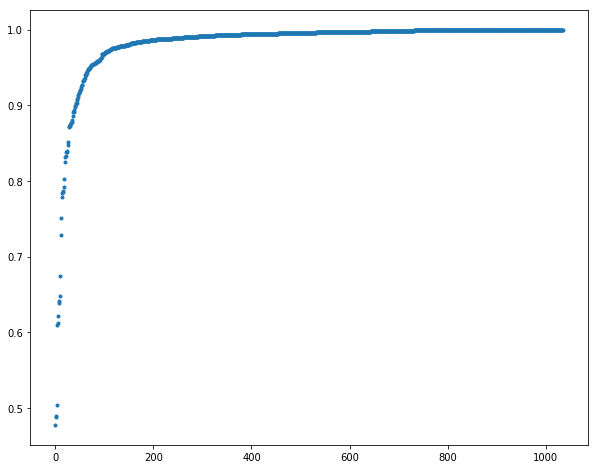

In [200]:
plt.figure(figsize=(10,8))
plt.plot(np.sort(similarity),'.')


In [201]:
np.quantile(similarity,0.05)

0.9214488979625074